# Fase 1: Discovery: data analysis.

## Imports and load data

# 1.0. Upload of used libraries

## Loading MLOPs framework libraries

In [1]:
from azureml.core import Workspace  
from amlops.mlodata import MLOData
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import re
import gc
import os

# Limpiamos notebook
gc.collect()

0

# 1.1. Loading data from the 'modelling' schema

## Data access and download

In [2]:
# Conexión al workspace de AzureML
workspace = Workspace.from_config()

# Definición de los ficheros a descargar del Datastore
datastore_name='data_service_data'
datastore_path_pattern = 'Credit_Admision_DemoData.csv'
separator_type = ';'

# Cargamos datos
df_aux = MLOData.load_path_as_df(workspace, datastore_name, datastore_path_pattern, separator_type)
df_aux.columns = (df_aux.iloc[0]).values
df_aux = df_aux[1:]

## Loaded data is displayed and dimensionality is studied


In [3]:
# Muestra de datos
print(f' Dimensión del dataset {df_aux.shape}')
df_aux.head()

 Dimensión del dataset (3168, 21)


,Month_ID,CCAA,First_Submission,SCF_Total_Amount_Financed,Other_Total_Amount_Financed,SCF_Interest_Rate,Other_Interest_Rate_Higher,SCF_Borrowing_Term,Other__Borrowing_Term,SCF_Amortization_Term,...,SCF_Monthly_Payment,Other_Monthly_Payment,SCF_Down_Payment,Other_Down_Payment,SCF_Initial_Credit_Decision_Time_Min,Other_Initial_Credit_Decision_Time_Min,SCF_Promotion_Campaign,Other_Promotion_Campaign,SCF_Funded,Ind_SCF_Funded
1,202007,CATALUÑA,N,"34930,32","34969,32","10,5",Yes,84,84,84,...,"588,0117",600-625,0,0,"10,5","1179,5",No,No,FUNDED,1
2,202007,PAIS VASCO,N,"28221,1","29279,04","11,99",Yes,78,84,78,...,"522,2317",650-675,0,0,"70,7","47,6",No,No,FUNDED,1
3,202007,PAIS VASCO,N,"35306,85",0,"8,99",Yes,72,None,72,...,"637,04",750-775,0,0,"86,4","214,3",No,No,FUNDED,1
4,202007,COMUNIDAD DE MADRID,N,"27083,87","28044,56","20,99",Yes,78,78,78,...,"640,1417",475-500,0,0,"3,3","14,2",No,No,FUNDED,1
5,202007,COMUNIDAD DE MADRID,Y,"15259,04","14583,3","11,99",Yes,72,66,72,...,"298,3717",325-350,0,0,"6,4","119,6",No,No,FUNDED,1


## The number of total columns, the data type of the columns, and if they have null values ​​are observed

In [4]:
df_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 1 to 3168
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   Month_ID                                3168 non-null   object
 1   CCAA                                    3168 non-null   object
 2   First_Submission                        3168 non-null   object
 3   SCF_Total_Amount_Financed               3168 non-null   object
 4   Other_Total_Amount_Financed             3168 non-null   object
 5   SCF_Interest_Rate                       3168 non-null   object
 6   Other_Interest_Rate_Higher              3168 non-null   object
 7   SCF_Borrowing_Term                      3168 non-null   object
 8   Other__Borrowing_Term                   3063 non-null   object
 9   SCF_Amortization_Term                   3168 non-null   object
 10  Other_Amortization_Term                 3014 non-null   object
 11  SCF_

Se observan columnas con datos a tratar, por ejemplo, _Other_Monthly_Payment_, en la que los valores son de tipo rango

In [5]:
df_aux['Other_Monthly_Payment']

1       600-625
2       650-675
3       750-775
4       475-500
5       325-350
         ...   
3164    475-500
3165    525-550
3166    300-325
3167    600-625
3168    425-450
Name: Other_Monthly_Payment, Length: 3168, dtype: object

## Data cleaning is performed

In [6]:
df_aux1 = df_aux.copy()
df_aux1['Other_Monthly_Payment'].fillna('0-0', inplace=True)
df_aux1['Mean_Monthly_Payment'] = [((int(x)+int(y))/2) for x,y in df_aux1['Other_Monthly_Payment'].str.split('-')]

Result of the variable _Other_Monthly_Payment_ after converting the value of type range to the mean
**Note**: two variables were also created, one with the minimum value of the range, and another with the maximum, but they had a high correlation, so it was preferred to take the mean.


In [7]:
df_aux1['Mean_Monthly_Payment'].head()

1    612.5
2    662.5
3    762.5
4    487.5
5    337.5
Name: Mean_Monthly_Payment, dtype: float64

## Elimination of the date variable, because all the data has the same date.

*Note:* In the transformation of variables, the value of *Month_ID* is separated by month and year. As each column has the same values ​​for its instances, and the correlation of this variable with the variable to be predicted is minimal, it is eliminated.

In [8]:
df_aux1['Month_ID'].value_counts()

202007    3168
Name: Month_ID, dtype: int64

In [9]:
df_aux1 = df_aux1.drop(['Month_ID', 'Other_Monthly_Payment'], axis=1)

## The resulting columns are observed after eliminating the variables _Month_ID_ and _Other_Monthly_Payment_

In [10]:
df_aux1.columns

Index(['CCAA', 'First_Submission', 'SCF_Total_Amount_Financed',
       'Other_Total_Amount_Financed', 'SCF_Interest_Rate',
       'Other_Interest_Rate_Higher', 'SCF_Borrowing_Term',
       'Other__Borrowing_Term', 'SCF_Amortization_Term',
       'Other_Amortization_Term', 'SCF_Monthly_Payment', 'SCF_Down_Payment',
       'Other_Down_Payment', 'SCF_Initial_Credit_Decision_Time_Min',
       'Other_Initial_Credit_Decision_Time_Min', 'SCF_Promotion_Campaign',
       'Other_Promotion_Campaign', 'SCF_Funded', 'Ind_SCF_Funded',
       'Mean_Monthly_Payment'],
      dtype='object')

### The **conversion** of **categorical** variables to **numeric** is performed.

Categorical variables are displayed

In [11]:
df_aux1[['CCAA', 'First_Submission', 'Other_Interest_Rate_Higher', 'SCF_Down_Payment', 'Other_Down_Payment', 'SCF_Promotion_Campaign', 'Other_Promotion_Campaign']]

,CCAA,First_Submission,Other_Interest_Rate_Higher,SCF_Down_Payment,Other_Down_Payment,SCF_Promotion_Campaign,Other_Promotion_Campaign
1,CATALUÑA,N,Yes,0,0,No,No
2,PAIS VASCO,N,Yes,0,0,No,No
3,PAIS VASCO,N,Yes,0,0,No,No
4,COMUNIDAD DE MADRID,N,Yes,0,0,No,No
5,COMUNIDAD DE MADRID,Y,Yes,0,0,No,No
...,...,...,...,...,...,...,...
3164,CATALUÑA,Y,No,0,0,No,No
3165,CATALUÑA,Y,No,500,0,No,No
3166,CANARIAS,N,No,0,0,No,No
3167,CATALUÑA,N,No,0,0,No,No


## A function is created to transform them to numerics through _Label Encoder_, and put __new_ after the name of the variable: _name_variable**_new**_

In [12]:
def transform_to_numeric(df:pd.DataFrame, colnames:list):
    le = LabelEncoder()
    for col in colnames:
        df[str(col)+'_New'] = pd.DataFrame(le.fit_transform(df[col]))
    return df

In [13]:
cols_to_encoder = ['CCAA', 'First_Submission', 'Other_Interest_Rate_Higher', 'SCF_Down_Payment', 'Other_Down_Payment', 'SCF_Promotion_Campaign', 'Other_Promotion_Campaign']
df_aux1 = transform_to_numeric(df_aux1, cols_to_encoder)
df_aux1 = df_aux1[df_aux1.columns[~df_aux1.columns.isin(cols_to_encoder)]]

### It shows how the data of the categorical variables are after the transformation

In [14]:
df_aux1[["CCAA_New","First_Submission_New","Other_Interest_Rate_Higher_New","SCF_Down_Payment_New","Other_Down_Payment_New","SCF_Promotion_Campaign_New","Other_Promotion_Campaign_New"]].head()

,CCAA_New,First_Submission_New,Other_Interest_Rate_Higher_New,SCF_Down_Payment_New,Other_Down_Payment_New,SCF_Promotion_Campaign_New,Other_Promotion_Campaign_New
1,9.0,0.0,1.0,0.0,0.0,0.0,0.0
2,9.0,0.0,1.0,0.0,0.0,0.0,0.0
3,6.0,0.0,1.0,0.0,0.0,0.0,0.0
4,6.0,1.0,1.0,0.0,0.0,0.0,0.0
5,8.0,1.0,1.0,0.0,0.0,0.0,0.0


## The data type of the variables is correctly established

**Note**: when loading the data, the data type of each variable was lost



In [15]:
df_aux1['SCF_Total_Amount_Financed'] = df_aux1['SCF_Total_Amount_Financed'].str.replace(',','.').astype('float64')
df_aux1['Other_Total_Amount_Financed'] = df_aux1['Other_Total_Amount_Financed'].str.replace(',','.').astype('float64')
df_aux1['SCF_Interest_Rate'] = df_aux1['SCF_Interest_Rate'].str.replace(',','.').astype('float64')
df_aux1['SCF_Borrowing_Term'] = df_aux1['SCF_Borrowing_Term'].str.replace(',','.').astype('int64')
df_aux1['Other__Borrowing_Term'] = df_aux1['Other__Borrowing_Term'].str.replace(',','.').astype('float64')
df_aux1['Other_Amortization_Term'] = df_aux1['Other_Amortization_Term'].str.replace(',','.').astype('float64')
df_aux1['SCF_Monthly_Payment'] = df_aux1['SCF_Monthly_Payment'].str.replace(',','.').astype('float64')
df_aux1['SCF_Initial_Credit_Decision_Time_Min'] = df_aux1['SCF_Initial_Credit_Decision_Time_Min'].str.replace(',','.').astype('float64')
df_aux1['Other_Initial_Credit_Decision_Time_Min'] = df_aux1['Other_Initial_Credit_Decision_Time_Min'].str.replace(',','.').astype('float64')

df_aux1['SCF_Borrowing_Term'] = df_aux1['SCF_Borrowing_Term'].astype('int64')
df_aux1['SCF_Amortization_Term'] = df_aux1['SCF_Amortization_Term'].astype('int64')
df_aux1['Ind_SCF_Funded'] = df_aux1['Ind_SCF_Funded'].astype('int64')

### The table is shown with the variables in the correct format



In [16]:
df_aux1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 1 to 3168
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   SCF_Total_Amount_Financed               3168 non-null   float64
 1   Other_Total_Amount_Financed             3168 non-null   float64
 2   SCF_Interest_Rate                       3168 non-null   float64
 3   SCF_Borrowing_Term                      3168 non-null   int64  
 4   Other__Borrowing_Term                   3063 non-null   float64
 5   SCF_Amortization_Term                   3168 non-null   int64  
 6   Other_Amortization_Term                 3014 non-null   float64
 7   SCF_Monthly_Payment                     3168 non-null   float64
 8   SCF_Initial_Credit_Decision_Time_Min    3168 non-null   float64
 9   Other_Initial_Credit_Decision_Time_Min  3168 non-null   float64
 10  SCF_Funded                              3168 non-null   obje

In [17]:
df_aux1.describe()

,SCF_Total_Amount_Financed,Other_Total_Amount_Financed,SCF_Interest_Rate,SCF_Borrowing_Term,Other__Borrowing_Term,SCF_Amortization_Term,Other_Amortization_Term,SCF_Monthly_Payment,SCF_Initial_Credit_Decision_Time_Min,Other_Initial_Credit_Decision_Time_Min,Ind_SCF_Funded,Mean_Monthly_Payment,CCAA_New,First_Submission_New,Other_Interest_Rate_Higher_New,SCF_Down_Payment_New,Other_Down_Payment_New,SCF_Promotion_Campaign_New,Other_Promotion_Campaign_New
count,3168.000000,3168.000000,3168.000000,3168.000000,3063.000000,3168.000000,3014.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.0,3167.000000
mean,23979.966170,25968.353339,21.014005,64.761364,74.109696,64.761364,73.988719,589.960813,81.909059,206.404230,0.147096,535.302241,5.044206,0.215977,0.157562,21.652037,23.053994,0.0,0.011999
std,9069.303993,12045.862121,6.714678,8.536694,11.360996,8.536694,11.430850,135.732859,622.826094,1184.477741,0.354257,159.186306,2.443280,0.411564,0.364388,46.185023,48.575207,0.0,0.108897
min,542.330000,0.000000,8.990000,12.000000,24.000000,12.000000,24.000000,10.710000,0.100000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,16694.250000,17631.820000,15.750000,60.000000,72.000000,60.000000,72.000000,533.432500,5.800000,27.200000,0.000000,437.500000,5.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,22178.390000,25044.050000,20.990000,60.000000,78.000000,60.000000,78.000000,572.585000,10.500000,61.600000,0.000000,512.500000,6.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,30128.500000,34159.410000,29.500000,72.000000,84.000000,72.000000,84.000000,700.000000,25.925000,120.425000,0.000000,637.500000,6.000000,0.000000,0.000000,0.000000,2.000000,0.0,0.000000
max,49842.370000,99999.000000,31.900000,84.000000,84.000000,84.000000,84.000000,847.925000,31701.200000,37518.500000,1.000000,1887.500000,9.000000,1.000000,1.000000,173.000000,192.000000,0.0,1.000000


In [18]:
df_aux1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 1 to 3168
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   SCF_Total_Amount_Financed               3168 non-null   float64
 1   Other_Total_Amount_Financed             3168 non-null   float64
 2   SCF_Interest_Rate                       3168 non-null   float64
 3   SCF_Borrowing_Term                      3168 non-null   int64  
 4   Other__Borrowing_Term                   3063 non-null   float64
 5   SCF_Amortization_Term                   3168 non-null   int64  
 6   Other_Amortization_Term                 3014 non-null   float64
 7   SCF_Monthly_Payment                     3168 non-null   float64
 8   SCF_Initial_Credit_Decision_Time_Min    3168 non-null   float64
 9   Other_Initial_Credit_Decision_Time_Min  3168 non-null   float64
 10  SCF_Funded                              3168 non-null   obje

The pyod library is used for outlier detection.


from pyod.models.knn import KNN
clf = KNN(contamination=0.18)
clf.fit(df_aux1)
y_pred = clf.predict(df_aux1)
df_aux1[y_pred ==1]

### Treatment of **Null Values**

*Note*: There are 266 null values, but they do not exceed 5% of the data in any of the columns, with most columns having null values ​​around 0.03% of the total data.

Missing values ​​are therefore replaced by the median.

In [19]:
if df_aux1.isnull().values.any():
    print(f'Número de valores nulos: {df_aux1.isnull().values.sum()} en columnas: {list(df_aux1.columns[df_aux1.isnull().any()])} \n ')
    print(f'El número de nulos de cada columna es:\n \
    {pd.DataFrame(df_aux1[df_aux1.columns[df_aux1.isnull().any()]].isnull().sum())} \n \n \
    Cuyo % de nulos del total es: \n \
    {(df_aux1[df_aux1.columns[df_aux1.isnull().any()]].isnull().sum()*100/len(df_aux1)).round(3)}')
else:
    print('No hay nulos')

Número de valores nulos: 266 en columnas: ['Other__Borrowing_Term', 'Other_Amortization_Term', 'CCAA_New', 'First_Submission_New', 'Other_Interest_Rate_Higher_New', 'SCF_Down_Payment_New', 'Other_Down_Payment_New', 'SCF_Promotion_Campaign_New', 'Other_Promotion_Campaign_New'] 
 
El número de nulos de cada columna es:
                                       0
Other__Borrowing_Term           105
Other_Amortization_Term         154
CCAA_New                          1
First_Submission_New              1
Other_Interest_Rate_Higher_New    1
SCF_Down_Payment_New              1
Other_Down_Payment_New            1
SCF_Promotion_Campaign_New        1
Other_Promotion_Campaign_New      1 
 
     Cuyo % de nulos del total es: 
     Other__Borrowing_Term             3.314
Other_Amortization_Term           4.861
CCAA_New                          0.032
First_Submission_New              0.032
Other_Interest_Rate_Higher_New    0.032
SCF_Down_Payment_New              0.032
Other_Down_Payment_New          

#### Perform a function to replace null values ​​with the median

In [20]:
def remplace_nulls(df_aux, cols:list):
    for col in cols:
        df_aux[col] = df_aux[col].fillna(df_aux[col].median())
    return df_aux

#### The number of nulls in the data set after processing is displayed

In [21]:
df_aux1 = remplace_nulls(df_aux1, list(df_aux1.columns[df_aux1.isnull().any()]))
print(f'Número de nulos en el dataset: {df_aux1.isnull().any().sum()}')

Número de nulos en el dataset: 0


## The influence of some variables with respect to the class is studied



In [22]:
df_aux1[['SCF_Total_Amount_Financed', 'Ind_SCF_Funded']].groupby(['Ind_SCF_Funded'], as_index=False).agg(['mean', 'count'])


SCF_Total_Amount_Financed      
                                    mean count
Ind_SCF_Funded                                
0                           23496.027143  2702
1                           26785.981730   466

#### The values ​​of the variable _SCF_Total_Amount_Financed_ are displayed, and for these values, to which class they belong



In [23]:
f1 = df_aux1['SCF_Total_Amount_Financed'].values
f2 = df_aux1.index
 
colores = ['orange','blue']
 
asignar=[]
for index, row in df_aux1.iterrows():    
        asignar.append(colores[row['Ind_SCF_Funded']])
 


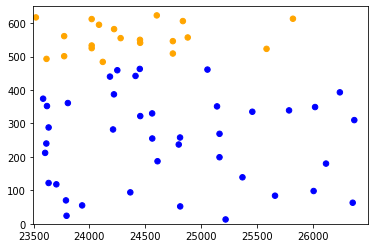

In [24]:
plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([23496,26496,0,650])
plt.show()

### Correlation of variables

The correlation between the variables is studied in order to see which ones are highly correlated and do not provide additional information to the data.

In [25]:
corr_matrix = df_aux1.corr(method='pearson').round(3)

Text(0.5, 1.0, 'Correlación de variables')

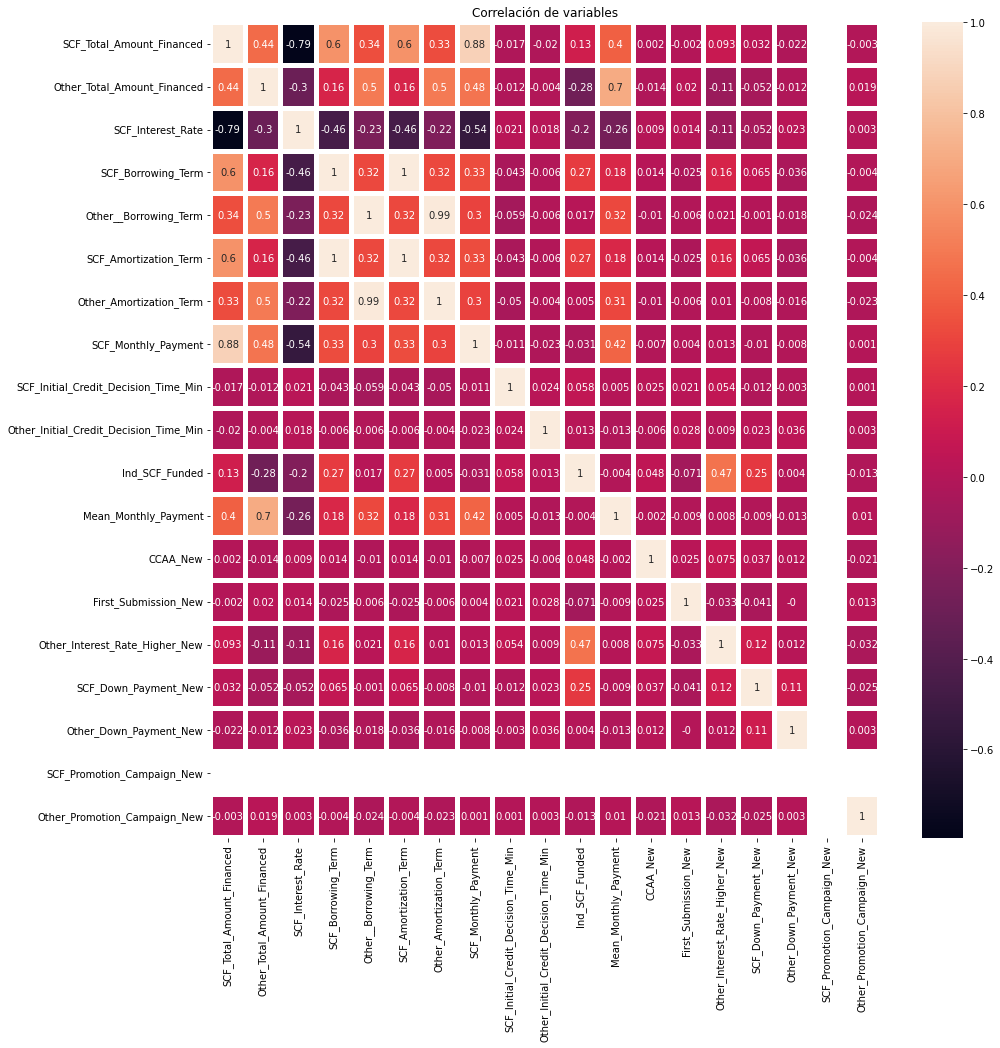

In [26]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, linewidths=-4, ax=ax)
plt.title("Correlación de variables")

#### The values ​​are ordered from highest to lowest correlation, and the pairs of variables with the highest positive correlation are displayed
*Note*: this means that the growth of one of the variables implies the growth of the other, that is, that
the values ​​of both variables tend to increase together.



In [27]:
corr_values = corr_matrix.unstack().sort_values(kind="quicksort")

In [28]:
corr_values[corr_values > 0.6].sort_values(ascending=False)

Other_Promotion_Campaign_New            Other_Promotion_Campaign_New              1.000
SCF_Amortization_Term                   SCF_Amortization_Term                     1.000
SCF_Total_Amount_Financed               SCF_Total_Amount_Financed                 1.000
SCF_Down_Payment_New                    SCF_Down_Payment_New                      1.000
Other_Total_Amount_Financed             Other_Total_Amount_Financed               1.000
SCF_Interest_Rate                       SCF_Interest_Rate                         1.000
SCF_Borrowing_Term                      SCF_Borrowing_Term                        1.000
                                        SCF_Amortization_Term                     1.000
SCF_Monthly_Payment                     SCF_Monthly_Payment                       1.000
SCF_Amortization_Term                   SCF_Borrowing_Term                        1.000
Other__Borrowing_Term                   Other__Borrowing_Term                     1.000
Other_Down_Payment_New          

#### The pairs of variables with the highest negative correlation are also shown
*Note*: means that the values ​​of one variable tend to increase while the values ​​of the other variable decrease.

In [29]:
corr_values[corr_values < -0.6]

SCF_Total_Amount_Financed  SCF_Interest_Rate           -0.794
SCF_Interest_Rate          SCF_Total_Amount_Financed   -0.794
dtype: float64

#### Of the highly correlated variables (both positively and negatively), the variance of each one is calculated, in order to eliminate the one that provides the least relevant information



In [30]:
df_aux1['Other__Borrowing_Term'].var()

125.27805207107109

In [31]:
df_aux1[['Other__Borrowing_Term', 'Other_Amortization_Term']].describe()

,Other__Borrowing_Term,Other_Amortization_Term
count,3168.000000,3168.000000
mean,74.238636,74.183712
std,11.192768,11.182798
min,24.000000,24.000000
25%,72.000000,72.000000
50%,78.000000,78.000000
75%,84.000000,84.000000
max,84.000000,84.000000


In [32]:
df_aux1[['Other__Borrowing_Term','Other_Amortization_Term']][(df_aux1['Other__Borrowing_Term']-df_aux1['Other_Amortization_Term'])!=0] 

,Other__Borrowing_Term,Other_Amortization_Term
11,84.0,78.0
12,84.0,72.0
17,60.0,48.0
20,60.0,78.0
33,72.0,60.0
...,...,...
425,72.0,78.0
436,72.0,78.0
456,84.0,78.0
462,72.0,78.0


### A table is displayed with the decisions made regarding the correlation matrix

Variable to be deleted | Decision
---|---
SCF_Borrowing_Term  -  SCF_Amortization_Term : 1                 | deletion SCF_Amortization 
Other_Monthly_Payment | is a range variable, two additional columns were made with the minimum value and the maximum value, and the correlation between both is 1, since the range is the same value, so it was decided to create a new varaible to replace this one and whose value is the average of the range
Other_Amortization_Term - Other__Borrowing_Term : 0.988          | deletion Other_Amortization_Term (because it has more std)
SCF_Funded_New - Ind_SCF_Funded : -1.000 by label encoder)  | deletion SCF_Funded_New
SCF_Total_Amount_Financed :  SCF_Monthly_Payment : 0.877         | It is calculated the correlation between the two with the log neperian (the decision was made no to delete, because it lowers the correlation to 0).739)
SCF_Total_Amount_Financed - SCF_Interest_Rate : -0.794 |

### Class balancing
A study is carried out to see the number of instances belonging to each class, to see if there is inequality between classes

In [33]:
df_aux1.Ind_SCF_Funded.value_counts() 

0    2702
1     466
Name: Ind_SCF_Funded, dtype: int64

In [34]:
print(f'El % de instancias para cada clase:\n {df_aux1.Ind_SCF_Funded.value_counts(normalize = True)*100}')

El % de instancias para cada clase:
 0    85.290404
1    14.709596
Name: Ind_SCF_Funded, dtype: float64


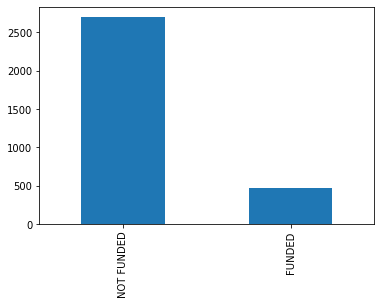

In [35]:
var = df_aux1['SCF_Funded'].value_counts()
var.plot(kind="bar")

**Decisions for class imbalance:**
1. Model parameter setting:
    - Within the algorithm itself
        - (weight adjustment on trees), minority class balance
            logisticregression: parameter class_weight= “balanced”
            
  
2. Modification of the dataset:
       - Remove samples from the majority class to balance
            Problem: loss of important samples and information
            Solution: Criteria for removal
       - Add new rows with minority class values
            Problem: the model can fall into Overfitting
            
            
3. Create artificial or synthetic samples:
    - Create synthetic samples (not identical) using various algorithms that try to follow the trend of the minority group.
        Problem: you can alter the natural distribution of the class and confuse the algorithm in the classification
            
            
4.Balanced Ensemble Methods:
    - Train various models and together obtain the final result (e.g. with vote). Makes sure to take balanced training samples



In [36]:
df_aux1 = df_aux1[df_aux1.columns[~df_aux1.columns.isin(['SCF_Amortization_Term', 'Other_Amortization_Term', 'SCF_Funded','SCF_Funded_New'])]]